<a href="https://colab.research.google.com/github/Durjoy18/Spam-SMS-DEtection/blob/main/spam_email_detection_using_multimonial_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/spam.csv", encoding='latin1')

In [8]:
import os

drive_path = '/content/drive/My Drive/Colab Notebooks/'

# Check if the directory exists
if os.path.exists(drive_path):
    print(f"Contents of '{drive_path}':")
    for item in os.listdir(drive_path):
        print(item)
else:
    print(f"The directory '{drive_path}' does not exist. Please check the path.")

Contents of '/content/drive/My Drive/Colab Notebooks/':
spam email detection using  multimonial naive bayes.ipynb
Proteinss.csv
Untitled0.ipynb
spam.csv


In [9]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report,
)

In [11]:
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False, regex=True)].copy()


In [12]:
cols = list(df.columns)
label_col = None
text_col = None

In [13]:
for c in cols:
    lc = c.lower()
    if lc in ["label", "target", "class", "category", "v1", "y"]:
        label_col = c
    if lc in ["text", "message", "sms", "content", "v2", "x"]:
        text_col = c

if label_col is None or text_col is None:
    label_col = cols[0]
    text_col = cols[1]

df = df[[label_col, text_col]].rename(columns={label_col: "label", text_col: "text"})

In [14]:
df = df.dropna(subset=["label", "text"]).copy()

In [16]:
label_str = df["label"].astype(str).str.lower().str.strip()
if set(label_str.unique()).issubset({"ham", "spam"}):
    df["y"] = label_str.map({"ham": 0, "spam": 1}).astype(int)
else:

    df["y"] = df["label"].astype("category").cat.codes

In [17]:
X = df["text"].astype(str)
y = df["y"].astype(int)


In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [19]:
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

True

In [28]:


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [21]:
print("Dataset shape:", df.shape)

Dataset shape: (5572, 3)


In [22]:
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [29]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [
        stemmer.stem(lemmatizer.lemmatize(w))
        for w in tokens if w not in stop_words
    ]
    return " ".join(tokens)

In [30]:
sample_text = df["text"].iloc[1]

In [31]:
print("\nOriginal text:")
print(sample_text)
print("\nProcessed text:")
print(preprocess_text(sample_text))


Original text:
Ok lar... Joking wif u oni...

Processed text:
ok lar joke wif u oni


In [45]:
X = df["text"]
y = df["y"] # Changed from df["label"] to df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])

Training samples: 4457
Testing samples : 1115


In [33]:
tfidf = TfidfVectorizer(preprocessor=preprocess_text, ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [34]:
print("TF-IDF train matrix shape:", X_train_tfidf.shape)
print("TF-IDF test matrix shape :", X_test_tfidf.shape)
print("Total vocabulary size    :", len(tfidf.vocabulary_))

TF-IDF train matrix shape: (4457, 30728)
TF-IDF test matrix shape : (1115, 30728)
Total vocabulary size    : 30728


In [35]:
from sklearn.naive_bayes import MultinomialNB

In [36]:
model = MultinomialNB(alpha=1.0)
model.fit(X_train_tfidf, y_train)

print("Model trained successfully")

Model trained successfully


In [37]:
y_pred = model.predict(X_test_tfidf)

In [38]:
print("First 10 actual labels   :", y_test.iloc[:10].values)
print("First 10 predicted labels:", y_pred[:10])

First 10 actual labels   : ['ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham']
First 10 predicted labels: ['ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham']


In [40]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label='spam')
rec = recall_score(y_test, y_pred, pos_label='spam')
f1 = f1_score(y_test, y_pred, pos_label='spam')

In [41]:
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-Score :", f1)

Accuracy : 0.957847533632287
Precision: 1.0
Recall   : 0.6845637583892618
F1-Score : 0.8127490039840638


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       966
        spam       1.00      0.68      0.81       149

    accuracy                           0.96      1115
   macro avg       0.98      0.84      0.89      1115
weighted avg       0.96      0.96      0.95      1115



In [48]:
 from sklearn.metrics import ConfusionMatrixDisplay


In [50]:
# Convert y_pred from string labels to numerical labels to match y_test
label_map = {'ham': 0, 'spam': 1}
y_pred_numeric = np.array([label_map[label] for label in y_pred])

cm = confusion_matrix(y_test, y_pred_numeric)
print("Confusion Matrix values:\n", cm)

Confusion Matrix values:
 [[966   0]
 [ 47 102]]


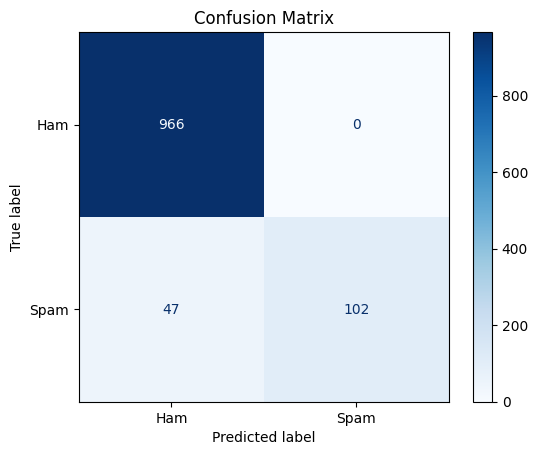

In [51]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Ham", "Spam"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [46]:
y_prob = model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

ROC AUC Score: 0.9706497422429725


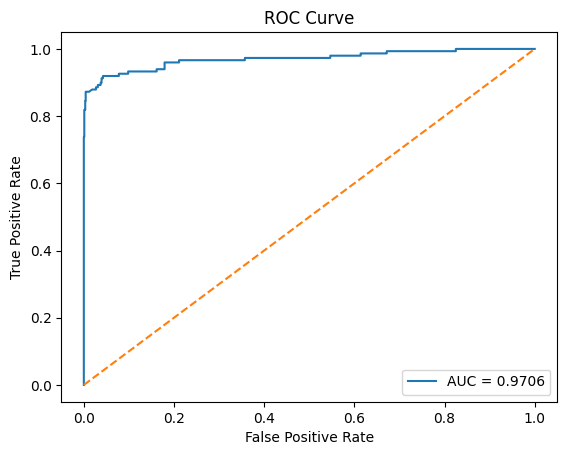

In [47]:
print("ROC AUC Score:", auc)

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()